### Benchmarking based on PXD013277

#### The dataset contains samples with different spiked in amounts of E.Coli protein extract (3 biological replicates) in MCF-7 background.  Each sample were labeled with an isobaric TMT-tag (TMT10-plex). Precursor mass tolerance used was 10 ppm, fragment mass tolerance 0.11 Da, fixed modifications were TMT-10plex on lysines and peptide N termini, and carbamidomethylation on cysteine residues, oxidation on methionine was used as a variable modification.

In [1]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
%%R
data_folder = '../../datasets/TMT/PXD013277'
setwd(data_folder)

In [4]:
# preprocess out_msstats.csv
import gzip

path = "out_msstats.csv.gz"
f_name = path.replace(".gz", "")
g_file = gzip.GzipFile(path)
with open(f_name, "wb+") as f:
    f.write(g_file.read())
    
path = "target_psmtable.txt.gz"
f_name = path.replace(".gz", "")
g_file = gzip.GzipFile(path)
with open(f_name, "wb+") as f:
    f.write(g_file.read())
    

In [4]:
quantmstmt = pd.read_csv("./out_msstats.csv", sep=',', header=0)
quantmstmt = quantmstmt[-quantmstmt['ProteinName'].str.contains("DECOY_")]
print(len(set(quantmstmt['ProteinName'])))
quantmstmt.head()

9624


,RetentionTime,ProteinName,PeptideSequence,Charge,Channel,Condition,BioReplicate,Run,Mixture,TechRepMixture,Fraction,Intensity,Reference
0,843.5067,sp|O76031|CLPX_HUMAN,.(TMT6plex)AAAAADLANR,2,4,breast adenocarcinoma|SP=Escherichia coli K-12...,4,1_1_22,1,1_1,22,1613933.0,GMHJYZ_DeqMSvalidation_300ug_TMT10_IPG3-10_fr3...
1,843.5067,sp|O76031|CLPX_HUMAN,.(TMT6plex)AAAAADLANR,2,5,breast adenocarcinoma|SP=Escherichia coli K-12...,5,1_1_22,1,1_1,22,1575278.0,GMHJYZ_DeqMSvalidation_300ug_TMT10_IPG3-10_fr3...
2,843.5067,sp|O76031|CLPX_HUMAN,.(TMT6plex)AAAAADLANR,2,6,breast adenocarcinoma|SP=Escherichia coli K-12...,6,1_1_22,1,1_1,22,1503877.0,GMHJYZ_DeqMSvalidation_300ug_TMT10_IPG3-10_fr3...
3,843.5067,sp|O76031|CLPX_HUMAN,.(TMT6plex)AAAAADLANR,2,7,breast adenocarcinoma|SP=Escherichia coli K-12...,7,1_1_22,1,1_1,22,1305303.0,GMHJYZ_DeqMSvalidation_300ug_TMT10_IPG3-10_fr3...
4,843.5067,sp|O76031|CLPX_HUMAN,.(TMT6plex)AAAAADLANR,2,10,breast adenocarcinoma|SP=Escherichia coli K-12...,10,1_1_22,1,1_1,22,1256989.0,GMHJYZ_DeqMSvalidation_300ug_TMT10_IPG3-10_fr3...


In [5]:
print(len(set(quantmstmt[quantmstmt['ProteinName'].str.contains("ECOLI")]['ProteinName'])))

2393


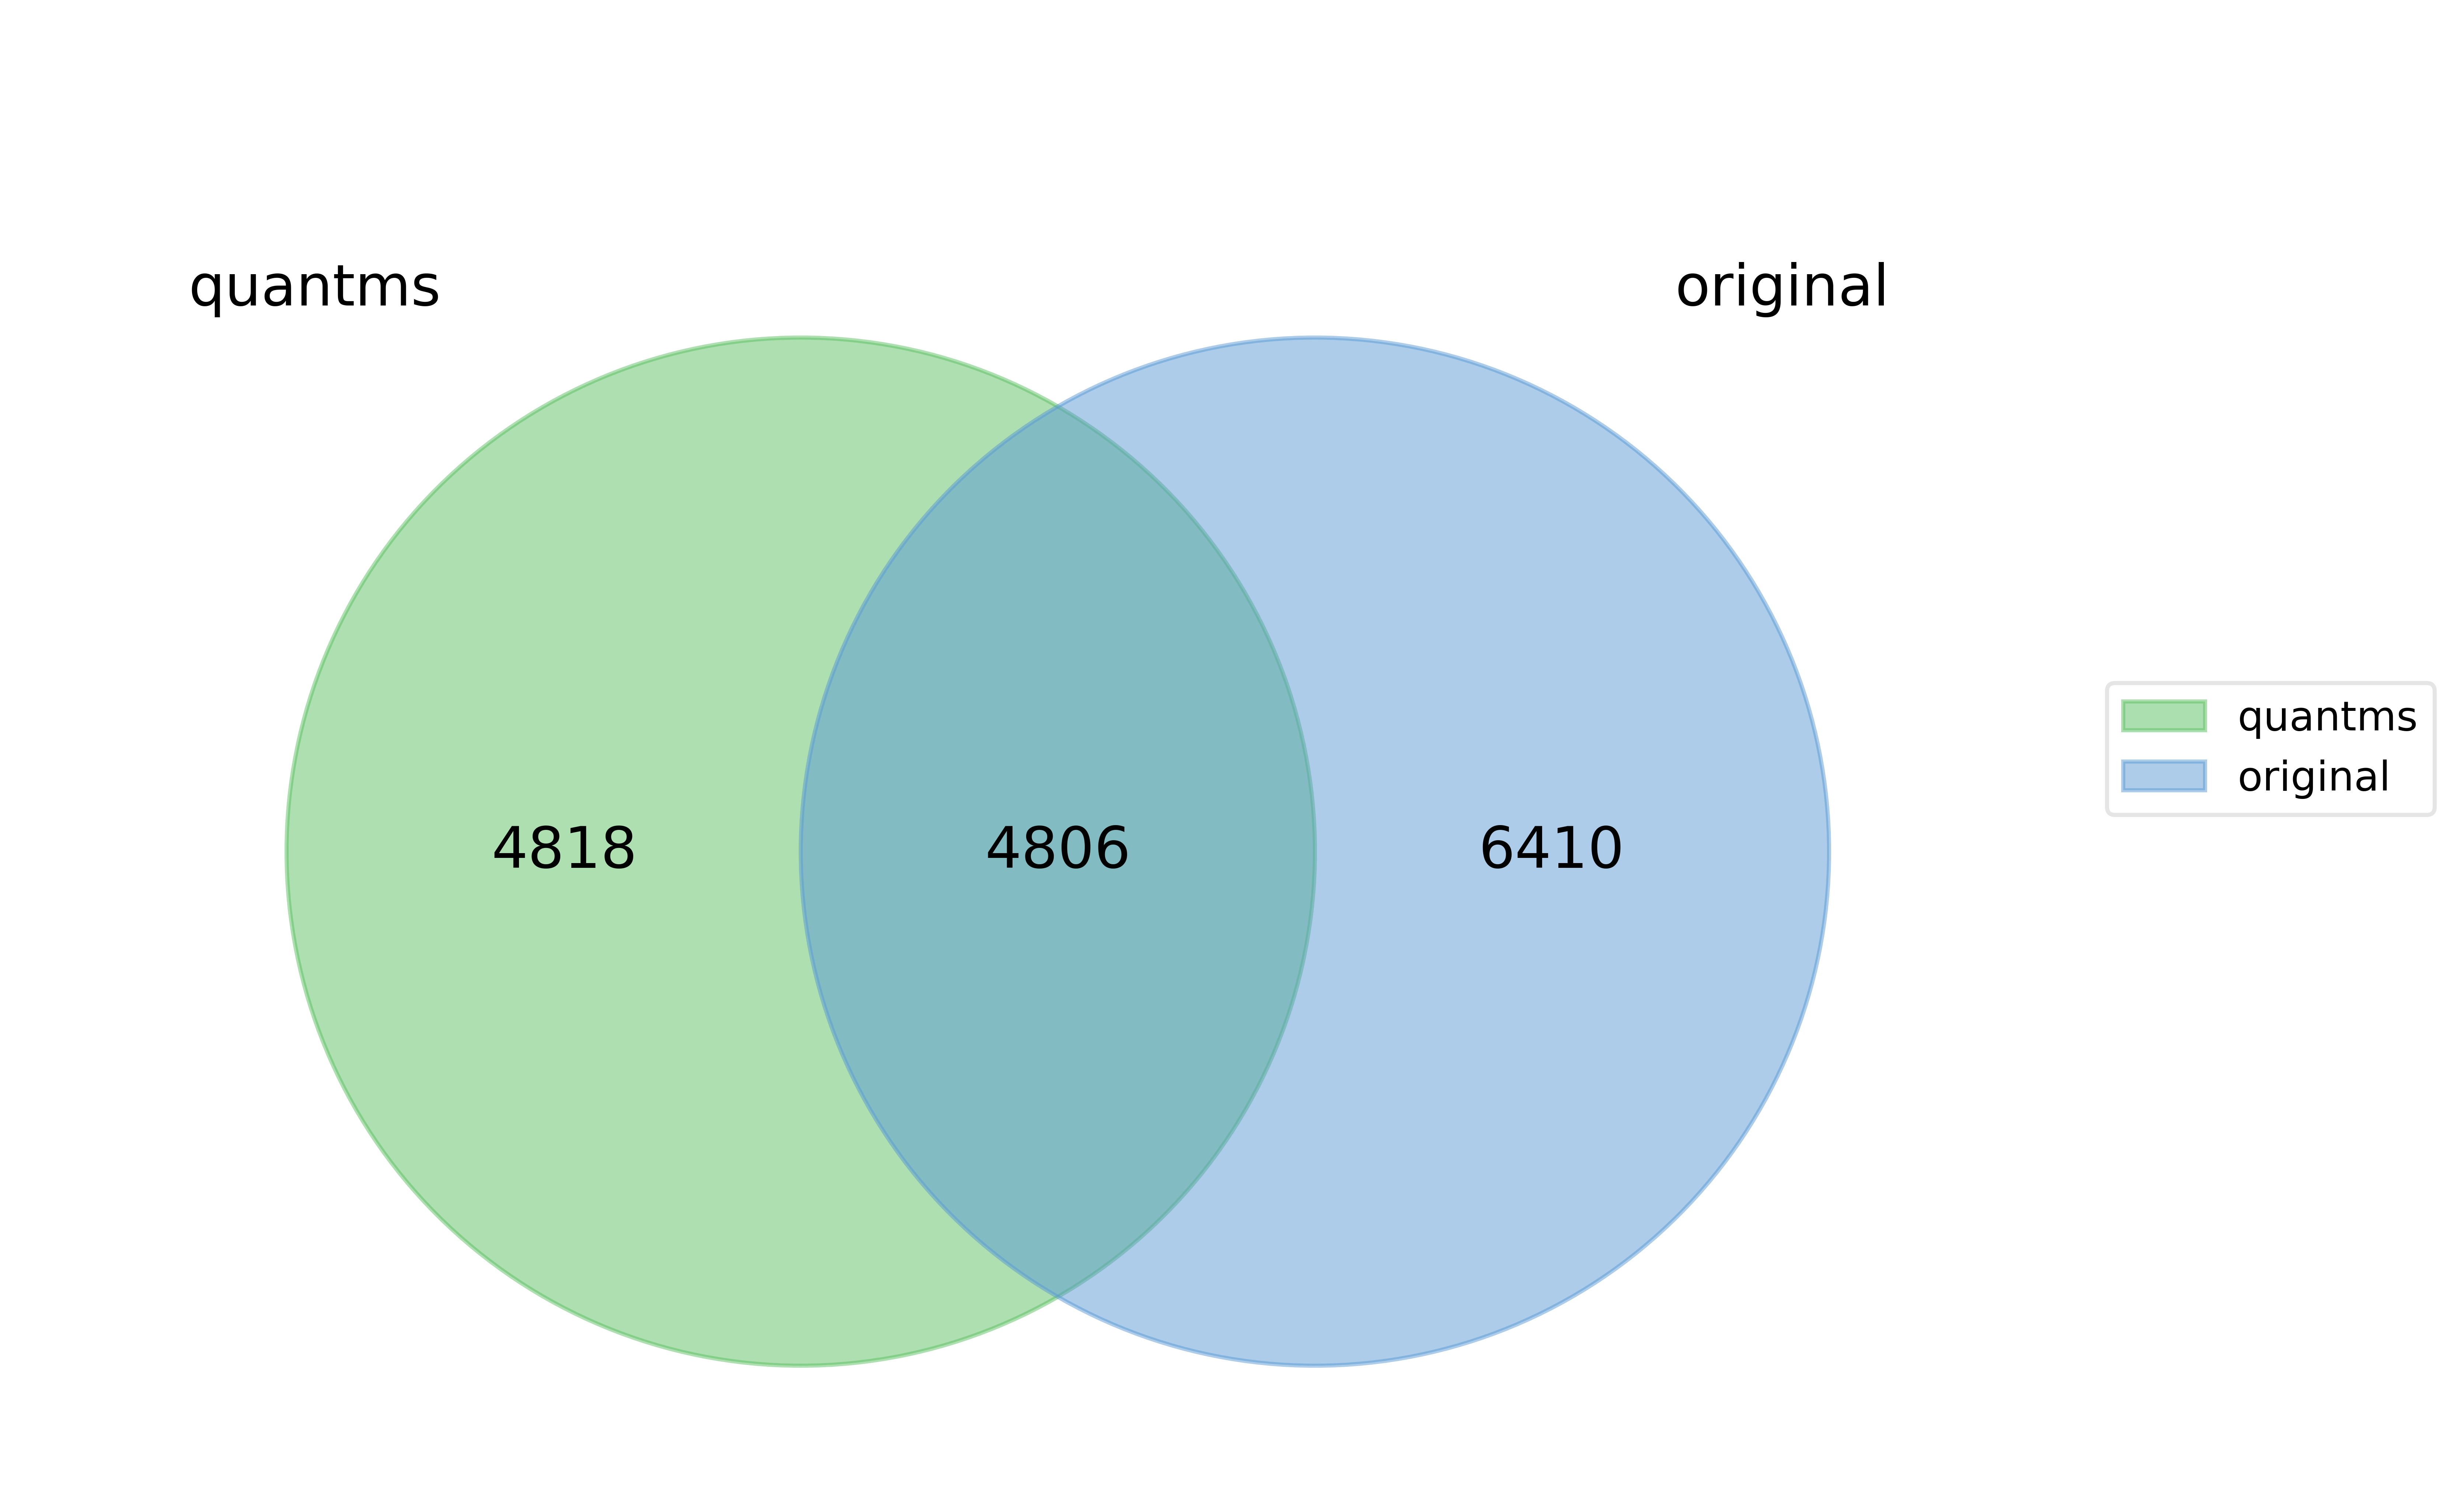

In [27]:
from matplotlib_venn import venn3
from pyvenn import venn
import re
from pyteomics import mztab

def clean_peptide(peptide):
    pattern = re.compile(r"\d+")
    a = re.sub(pattern,"", peptide).replace("+", "").replace(".", "")
    return a

def dis_decoy02(x):
    if 'CONTAMINANT_'in x['accession'] or 'DECOY_' in x['accession']:
        return True
    else:
        return False
    
quantmsmztab = mztab.MzTab("out.mzTab")
quantmspeptide = quantmsmztab.peptide_table
quantmspeptide = quantmspeptide[quantmspeptide['opt_global_cv_MS:1002217_decoy_peptide'] != 1]
quantmsprot = quantmsmztab.protein_table
quantmsprot['decoy'] = quantmsprot.apply(lambda x: dis_decoy02(x) , axis=1)
quantmsprot.drop(quantmsprot[quantmsprot['decoy'] == True].index, inplace=True)

# read the original result
# OriginalResult = pd.read_excel("./TMT EColi spike in to  MCF7 protein groups.xlsx", sheet_name="Proteins group table", header=0)
# plt.figure(figsize=(6,6),dpi=800)
# venn3([set(quantmstmt["ProteinName"]), set(OriginalResult['Protein accession']), set(quantmsprot['accession'])], set_labels=('quantmsquant', 'original', 'quantmsidentified'))
# plt.show()

# read the original result
OriginalResult = pd.read_excel("./TMT EColi spike in to  MCF7 protein groups.xlsx", sheet_name="Proteins group table", header=0)
OriginalResult['Proteins in group'] = OriginalResult.apply(lambda x: ";".join(sorted(x['Proteins in group'].replace(",", ";").split(";"))), axis=1)
quantmstmt['newProteinName'] = quantmstmt.apply(lambda x: ";".join(sorted(x['ProteinName'].split(";"))), axis=1)
labels = venn.get_labels([set(quantmstmt["newProteinName"]), set(OriginalResult['Proteins in group'])], fill=['number'])
fig, ax = venn.venn2(labels, names=['quantms', 'original'], dpi=800)
plt.show()

In [19]:
pro_iden = set(quantmsprot[quantmsprot['opt_global_result_type'] == "single_protein"]['accession']).union(set(quantmsprot[quantmsprot['opt_global_result_type'] == "indistinguishable_protein_group"]['ambiguity_members']))
pro_iden = set(list(map(lambda x: x.replace(",", ";"), pro_iden)))
print(len(set(pro_iden)))

9624


In [15]:
quantmsprot['ambiguity_members'].tail()

accession
sp|P43004|EAA2_HUMAN     sp|P43004|EAA2_HUMAN,tr|A0A163QEF0|A0A163QEF0_...
sp|Q9BY41|HDAC8_HUMAN    sp|Q9BY41|HDAC8_HUMAN,tr|A0A3B3IRI9|A0A3B3IRI9...
sp|Q29980|MICB_HUMAN     sp|Q29980|MICB_HUMAN,tr|A0A024RCL3|A0A024RCL3_...
sp|Q8NHS3|MFSD8_HUMAN    sp|Q8NHS3|MFSD8_HUMAN,tr|A0A286YER2|A0A286YER2...
sp|Q1MSJ5|CSPP1_HUMAN    sp|Q1MSJ5|CSPP1_HUMAN,tr|A0A6Q8PF61|A0A6Q8PF61...
Name: ambiguity_members, dtype: object

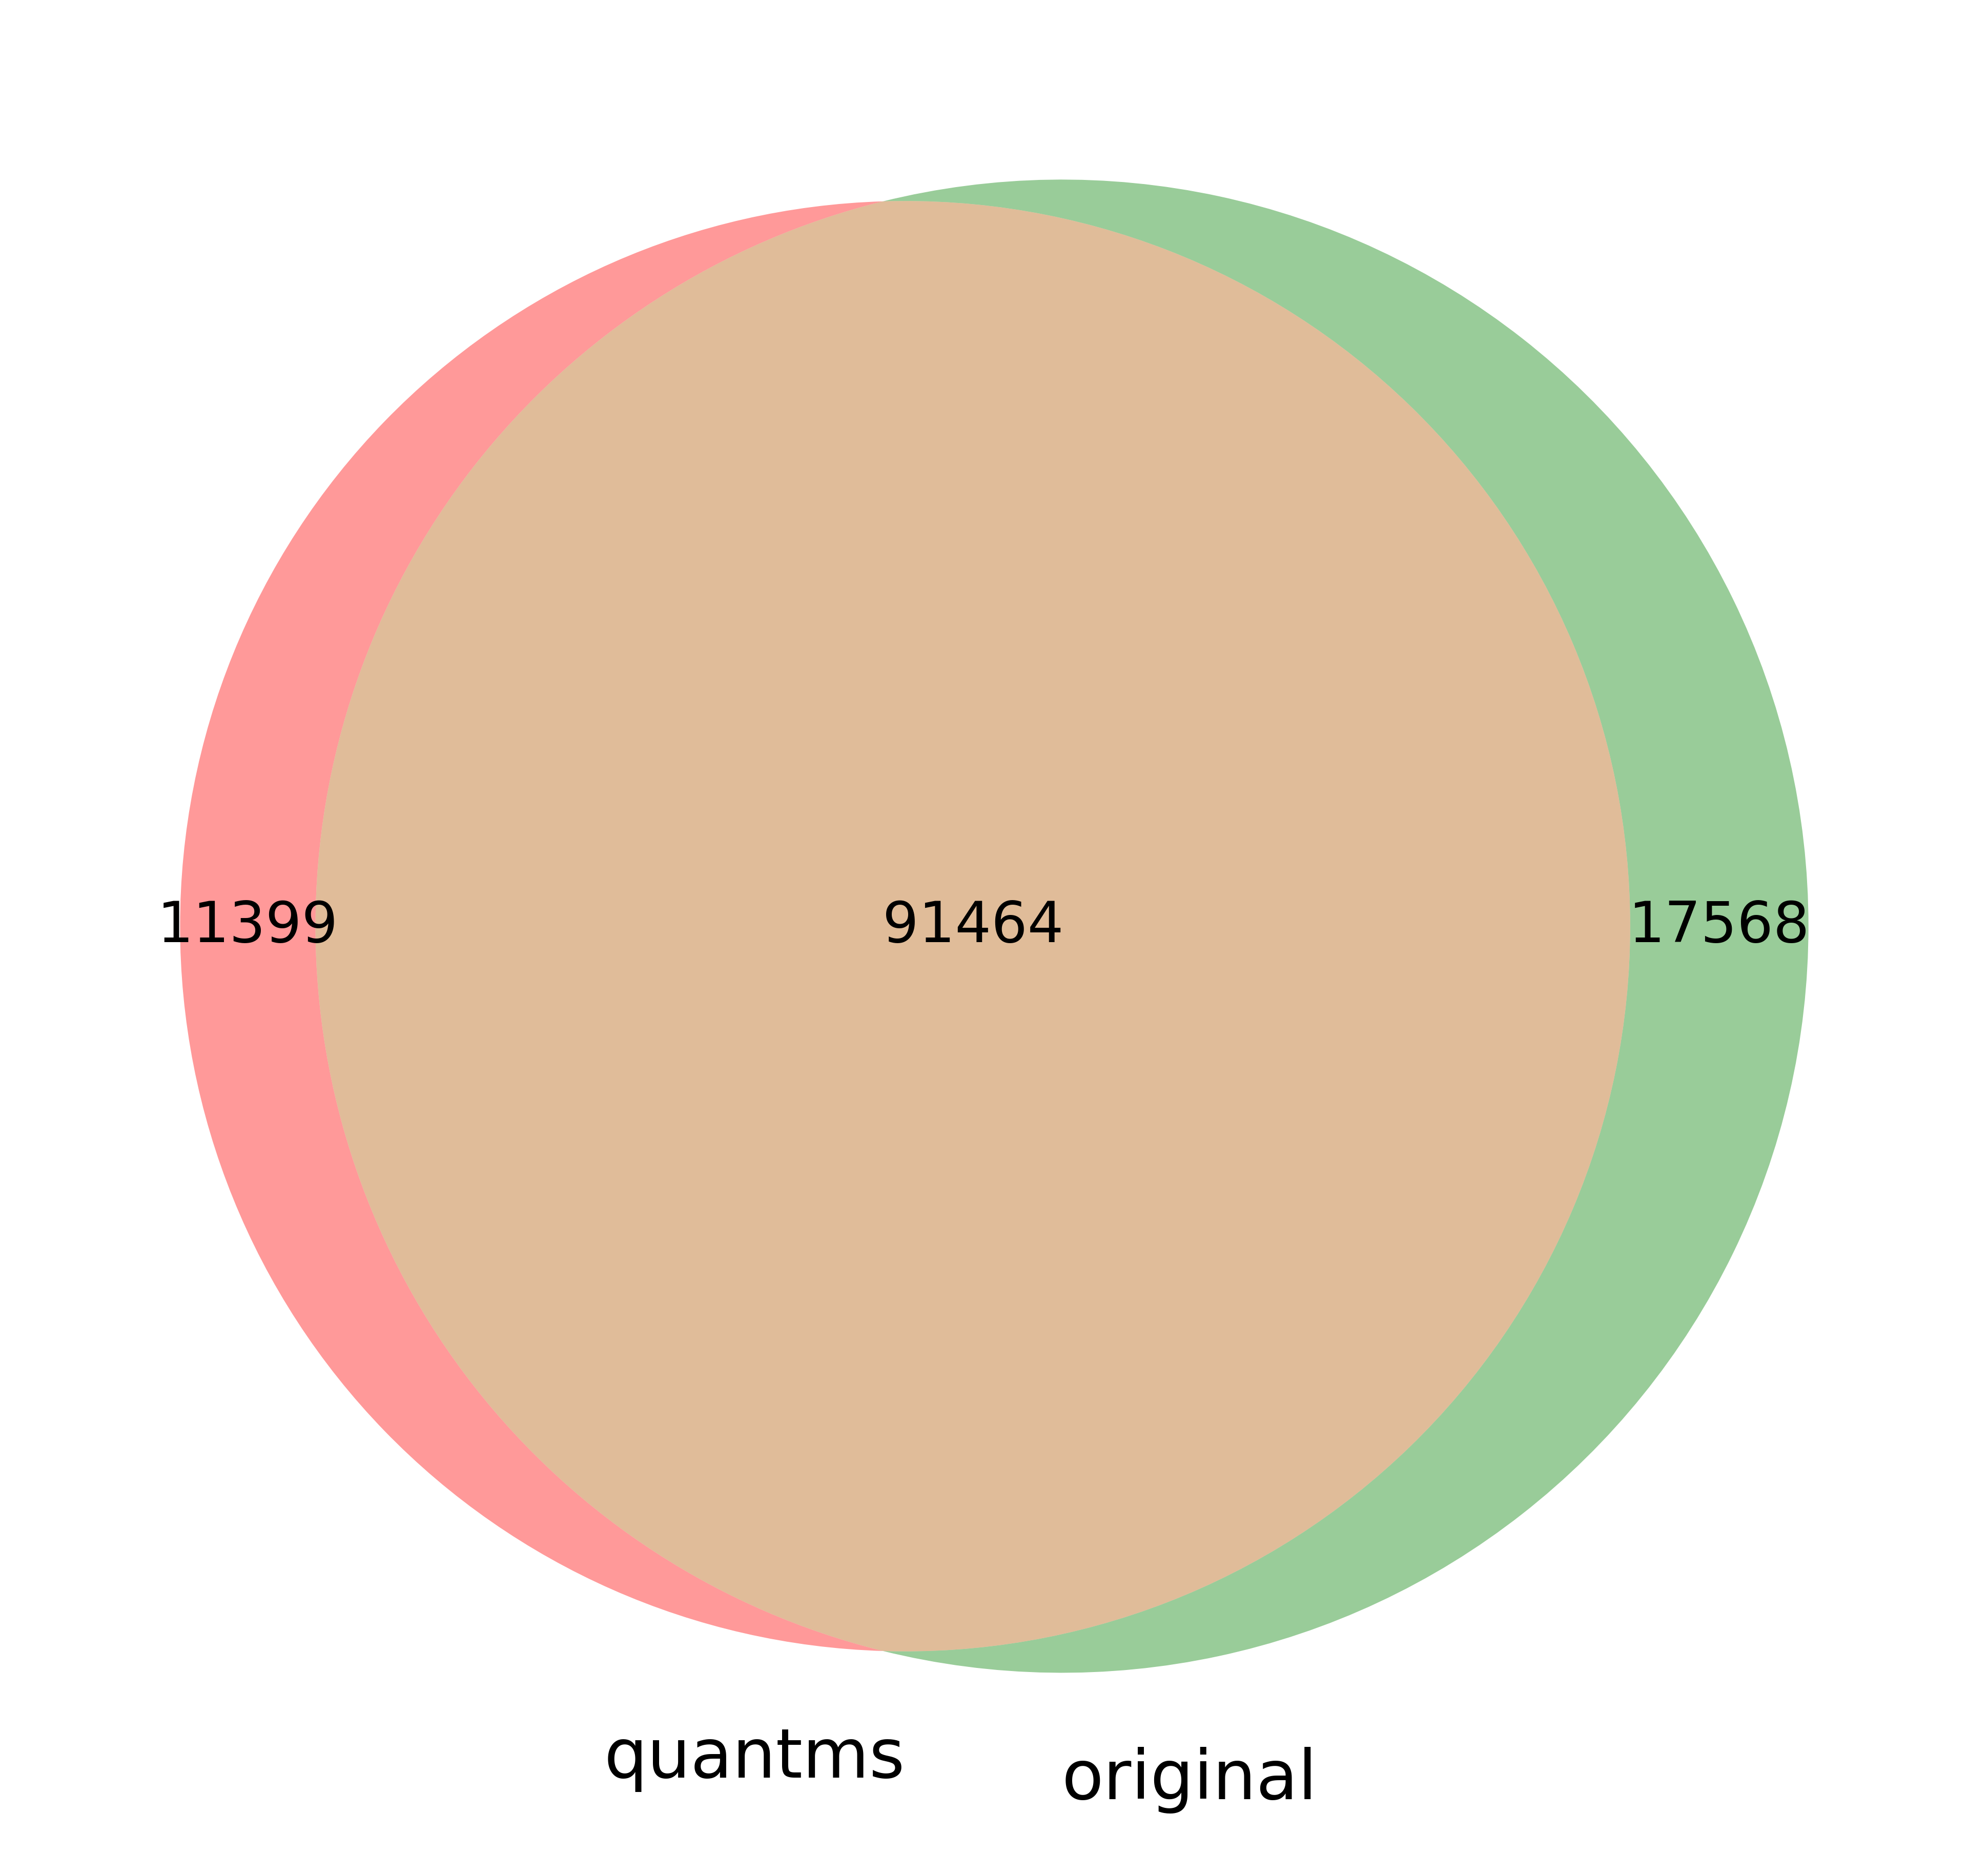

In [33]:
plt.figure(figsize=(6,6),dpi=800)
venn2([set(quantmspeptide["sequence"]), set(OriginalPSM['Peptide'])], set_labels=('quantms', 'original'))
plt.show()

INFO  [2022-01-09 16:16:06] ** Raw data from OpenMS imported successfully.
INFO  [2022-01-09 16:16:10] ** Raw data from OpenMS cleaned successfully.
INFO  [2022-01-09 16:16:11] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements within each run will be removed.
INFO  [2022-01-09 16:16:11] ** Features with all missing measurements across channels within each run are removed.
INFO  [2022-01-09 16:16:12] ** Shared peptides are removed.
INFO  [2022-01-09 16:16:13] ** Features with one or two measurements across channels within each run are removed.
INFO  [2022-01-09 16:16:44] ** PSMs have been aggregated to peptide ions.
INFO  [2022-01-09 16:17:00] ** For peptides overlapped between fractions of 1_1_1 use the fraction with maximal average abundance.
INFO  [2022-01-09 16:17:00] ** Fractions belongin

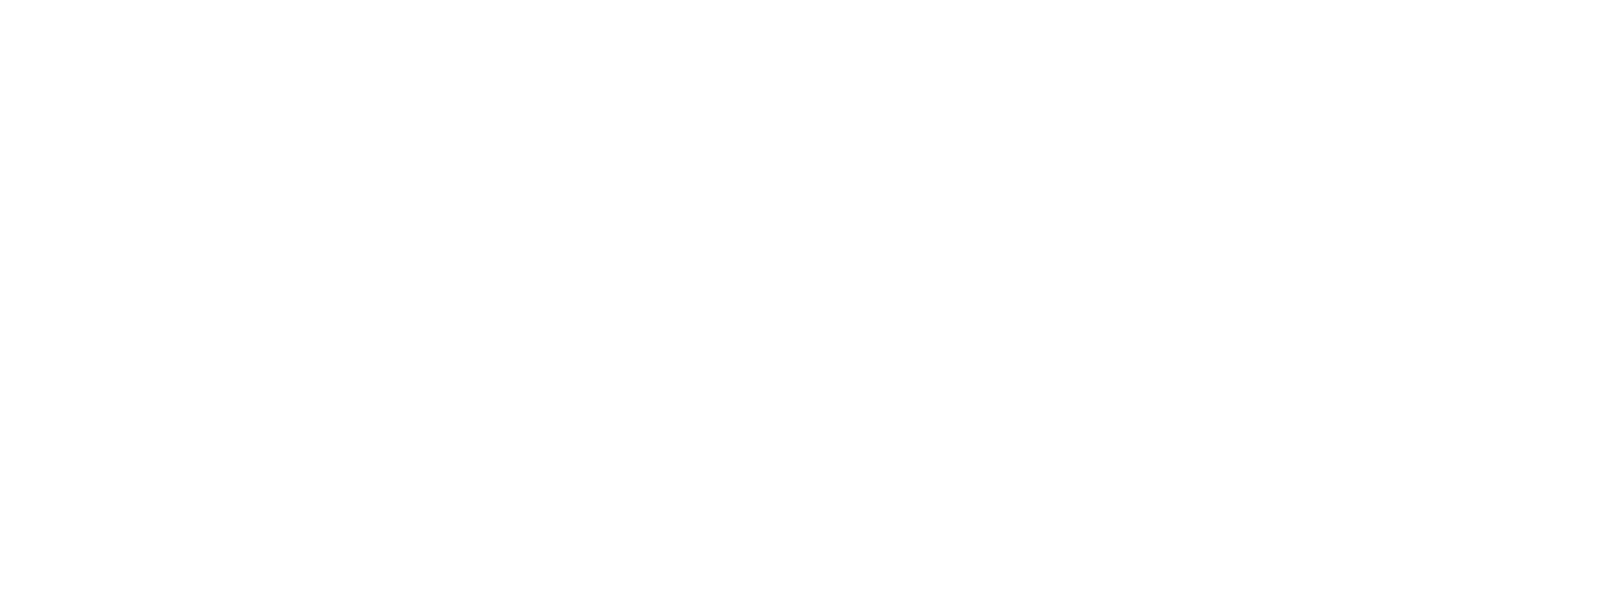

In [15]:
%%R -w 1600 -h 600

library('MSstatsTMT', warn.conflicts = F, quietly = T, verbose = F)
openms_output = './out_msstats.csv'
raw.om <- read.csv(openms_output, header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]
input.om <- OpenMStoMSstatsTMTFormat(raw.om)
head(input.om)

From cffi callback <function _consolewrite_ex at 0x0000023F2A16A798>:
Traceback (most recent call last):
  File "C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\rinterface_lib\callbacks.py", line 132, in _consolewrite_ex
    s = conversion._cchar_to_str_with_maxlen(buf, n, _CCHAR_ENCODING)
  File "C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\rinterface_lib\conversion.py", line 133, in _cchar_to_str_with_maxlen
    s = ffi.string(c, maxlen).decode(encoding)
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd4 in position 1: invalid continuation byte
R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




INFO  [2022-01-09 16:17:03] ** MSstatsTMT - proteinSummarization function
INFO  [2022-01-09 16:17:04] Summarizing for Run : 1_1_1 ( 1  of  1 )
  |======================================================================| 100%
INFO  [2022-01-09 16:23:30] ** Protein-level summarization done by MSstats.


R[write to console]: Drew the Profile plot for 1 proteins.



  |======================================================================| 100%


R[write to console]: Drew the Profile plot with summarization for 1 proteins.



  |======================================================================| 100%


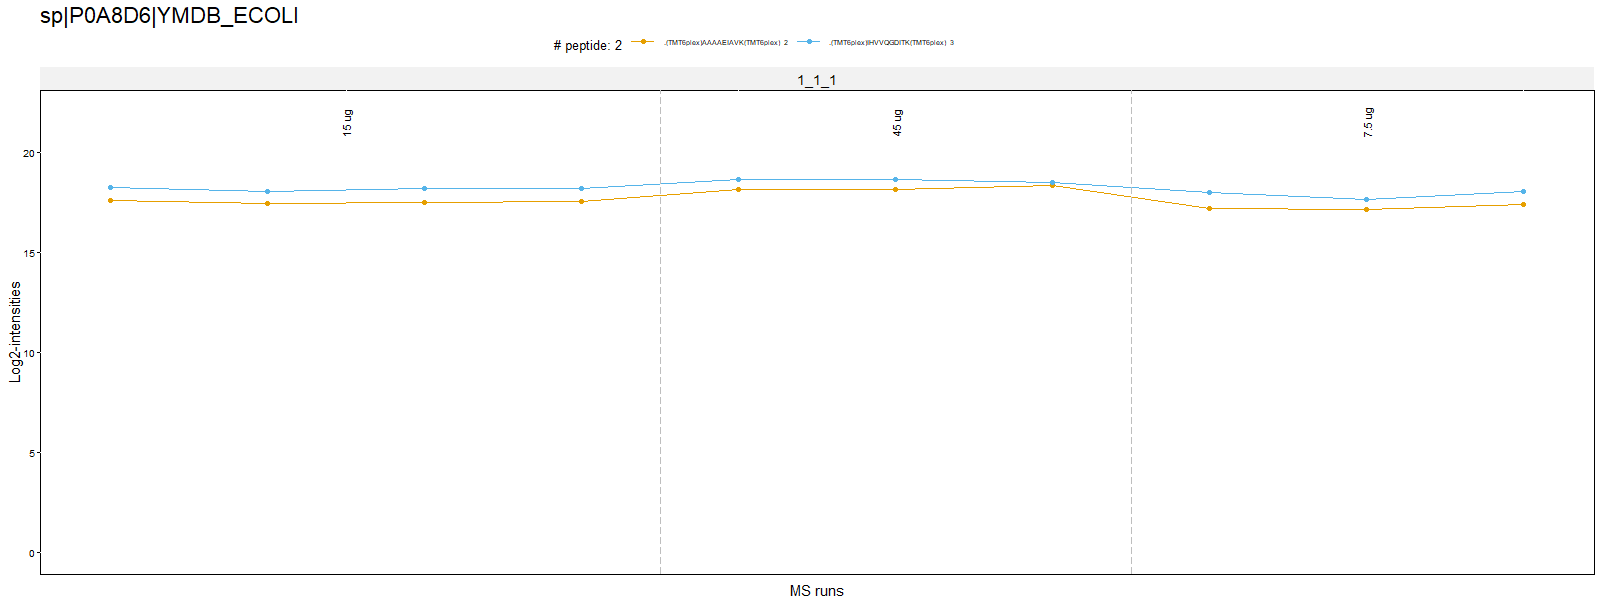

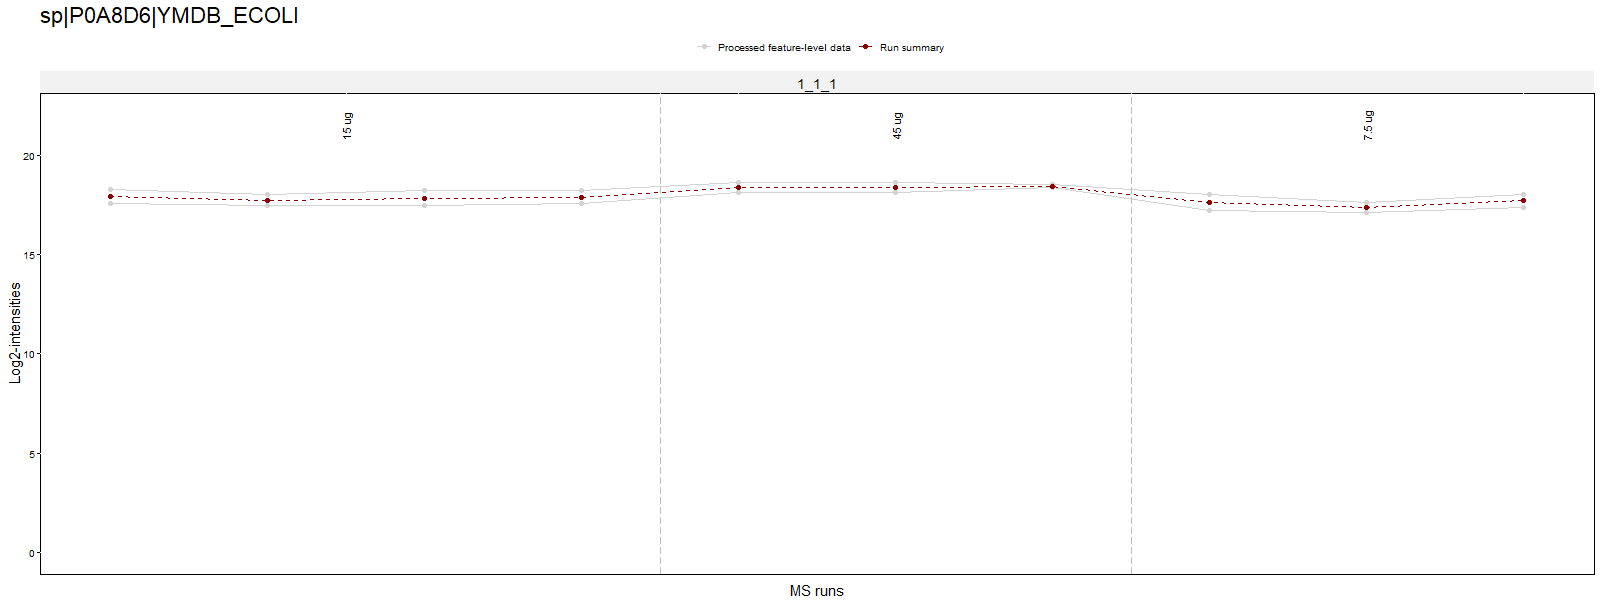

In [16]:
%%R -w 1600 -h 600
library("dplyr")
input.om$Condition = data.frame(input.om)%>%select(Condition)%>%
    mutate(Condition=case_when(input.om$Condition == "breast adenocarcinoma|SP=Escherichia coli K-12;CT=Mixture;QY=7.5 ug;CV=in-house"~"7.5 ug",
        input.om$Condition == "breast adenocarcinoma|SP=Escherichia coli K-12;CT=Mixture;QY=15 ug;CV=in-house"~"15 ug",
        input.om$Condition == "breast adenocarcinoma|SP=Escherichia coli K-12;CT=Mixture;QY=45 ug;CV=in-house"~"45 ug"))

# use MSstatsTMT for protein summarization
quant_om.msstats <- proteinSummarization(input.om,
                                      method="msstats",
                                      global_norm=TRUE,
                                      reference_norm=FALSE,
                                      remove_norm_channel = FALSE,
                                      remove_empty_channel = TRUE)

## Profile plot without norm channnels and empty channels
dataProcessPlotsTMT(data=quant_om.msstats,
                     type = 'ProfilePlot',
                     which.Protein = 'sp|P0A8D6|YMDB_ECOLI',  # spiked-in protein
                     width = 25, # adjust the figure width 
                     height = 12,
                     address=FALSE)

R[write to console]: Drew the Quality Contol plot(boxplot) over all proteins.



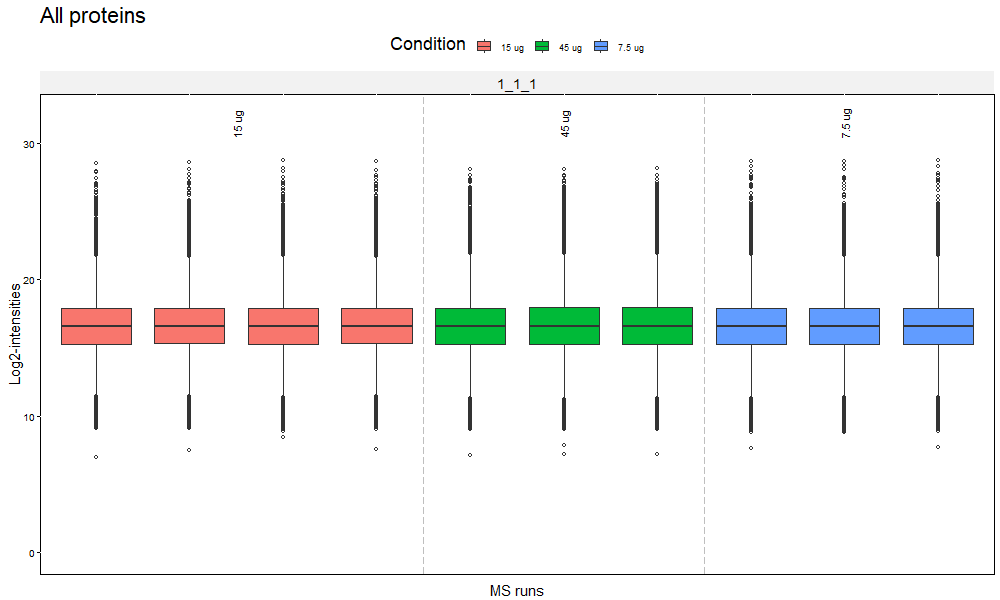

In [17]:
%%R -w 1000 -h 600

tmp <- levels(input.om$ProteinName)
selector <- append('allonly', tmp, 1)
## Quality control plot 
dataProcessPlotsTMT(data=quant_om.msstats, 
                     type='QCPlot',
                     which.Protein=selector,
                     width = 25, # adjust the figure width
                     height = 12,
                     address = FALSE)

In [18]:
%%R

levels(quant_om.msstats$ProteinLevelData$Condition)

[1] "15 ug"  "45 ug"  "7.5 ug"


In [19]:
%%R -w 1000 -h 600

TMT_Comp<-matrix(c(1, 0, -1, 0, 1, 1, -1, -1, 0), nrow=3)
row.names(TMT_Comp)<-c("15 vs 7.5", "45 vs 7.5", "45 vs 15")
colnames(TMT_Comp) = c("15 ug","45 ug", "7.5 ug")


TMT_Comp.pairwise <- groupComparisonTMT(quant_om.msstats, contrast.matrix = TMT_Comp, moderated = TRUE)

head(TMT_Comp.pairwise$ComparisonResult)
write.csv(TMT_Comp.pairwise$ComparisonResult, 'comparison_res.csv', row.names=FALSE,col.names=TRUE,sep=",")

INFO  [2022-01-09 16:23:40] Model fitting for 9623 proteins.
  |======================================================================| 100%
INFO  [2022-01-09 16:24:53] Testing for 9623 proteins:
  |======================================================================| 100%


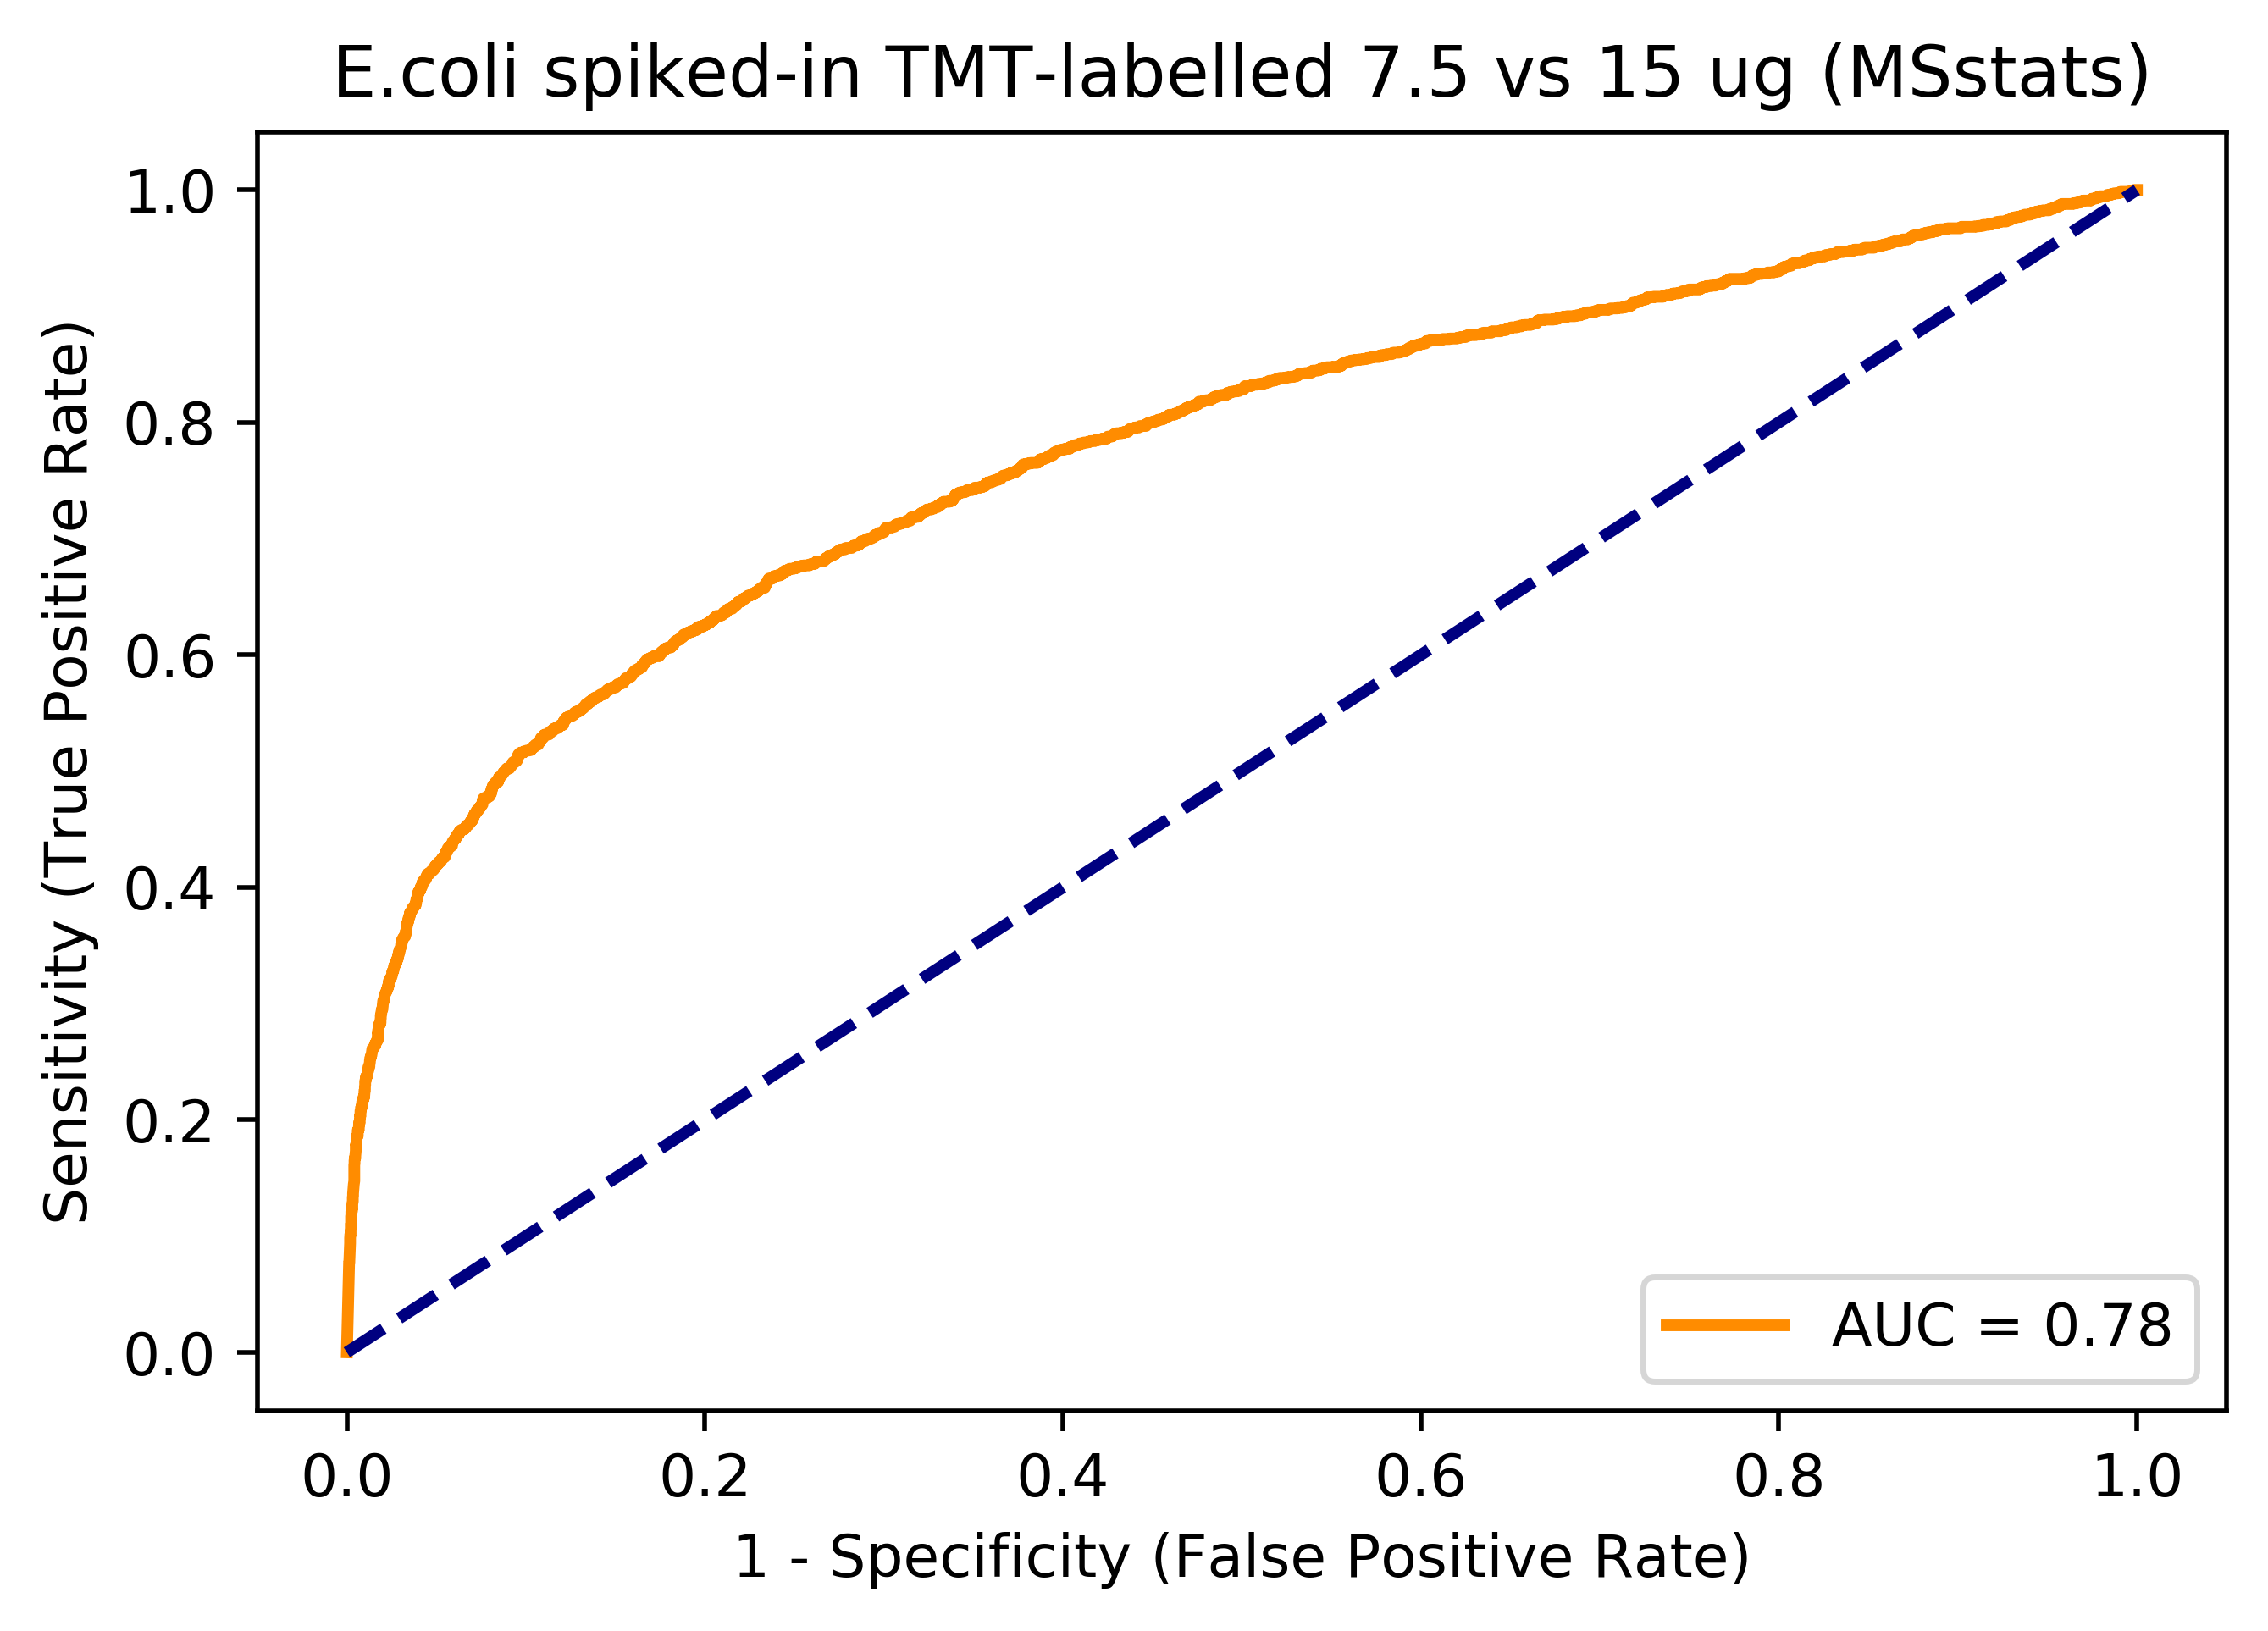

In [20]:
from sklearn import metrics

# filtered out missing value
compar_res = pd.read_csv("comparison_res.csv", sep=',', header=0)
compar_res = compar_res.query('(issue != issue) & (pvalue == pvalue)')


compar_res['value'] = 1 - compar_res['adj.pvalue']
compar_res['y'] = compar_res['Protein'].map(lambda x: ("ECOLI" in x and 1) or ("ECOLI" not in x and 0))
compar_res = compar_res[compar_res['Label'] == "15 vs 7.5"]
compar_res = compar_res.sort_values(by="adj.pvalue", ascending=True)

fpr, tpr, thresholds = metrics.roc_curve(compar_res['y'].tolist(), compar_res['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)

plt.figure(dpi=500)

plt.plot(fpr, tpr, color="darkorange", lw=2, label="AUC = %0.2f" % auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("E.coli spiked-in TMT-labelled 7.5 vs 15 ug (MSstats)")
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.legend(loc="lower right")


In [21]:
compar_res['significant'] = compar_res.apply(lambda x: True if x['adj.pvalue'] < 0.01 else False, axis=1)

ecoli = compar_res[compar_res['Protein'].str.contains("ECOLI")]
human = compar_res[compar_res['Protein'].str.contains('HUMAN')]
TP = len(ecoli[ecoli['significant'] == True])
FP = len(human[human['significant'] == True])
print(TP)
print(FP)

1085
488


### Runing with Proteus and Limma

In [22]:
%%R
library(proteusTMT)

In [48]:
import re
from collections import Counter

def clean_PeptideSequence(pep_seq):
    pattern = re.compile(r"\(.*?\)")
    pep_seq = pep_seq.replace(".", "")
    return pattern.sub("", pep_seq)

def modified_PeptideSequence(pep_seq):
    pattern = re.compile(r"\(.*?\)")
    t_pep_seq = pep_seq.replace(".", "").replace("Acetyl", "ac").replace("Carbamidomethyl", "ca").replace("Oxidation", "ox")
    t_pep_seq = "_" + t_pep_seq + "_"

def get_modifications(pep_seq):
    pattern = re.compile(r"\(.*?\)")
    t = ""
    modifications = re.findall(pattern, pep_seq)
    if len(modifications) == 0:
        return "Unmodified"
    c = Counter(modifications)
    for key, value in c.items():
        if value == 1:
            c[key] = ""
        else:
            c[key] = str(c[key]) + " "
    modifications = ",".join(set(modifications))
    if "(Acetyl)" in c:
        modifications = modifications.replace("(Acetyl)", c["(Acetyl)"] + "Acetyl (Protein N-term)")
    if "(Carbamidomethyl)" in c:
        modifications = modifications.replace("(Carbamidomethyl)", c["(Carbamidomethyl)"] + "Carbamidomethyl (C)")
    if "(Oxidation)" in c:
        modifications = modifications.replace("(Oxidation)", c["(Oxidation)"] + "Oxidation (M)")
        
    return modifications

quantms = pd.read_csv("./out_msstats.csv", sep=',', header=0)
quantms = quantms[-quantms['ProteinName'].str.contains("DECOY_")]
evi = pd.DataFrame(None, columns=['sequence', 'modified_sequence', 'protein_group', 'proteins',
                                  'protein', 'charge', 'reverse', 'contaminant', 'reporter_0', 'reporter_1', 'reporter_2',
                                 'reporter_3', 'reporter_4', 'reporter_5', 'reporter_6', 'reporter_7', 'reporter_8', 'reporter_9'])

for name, group in quantms.groupby(['PeptideSequence', 'ProteinName', 'Charge', 'Fraction']):
    reporter_0 = group[group['Channel'] == 1]['Intensity'].values[0] if 1 in list(group['Channel']) else ''
    reporter_1 = group[group['Channel'] == 2]['Intensity'].values[0] if 2 in list(group['Channel']) else ''
    reporter_2 = group[group['Channel'] == 3]['Intensity'].values[0] if 3 in list(group['Channel']) else ''
    reporter_3 = group[group['Channel'] == 4]['Intensity'].values[0] if 4 in list(group['Channel']) else ''
    reporter_4 = group[group['Channel'] == 5]['Intensity'].values[0] if 5 in list(group['Channel']) else ''
    reporter_5 = group[group['Channel'] == 6]['Intensity'].values[0] if 6 in list(group['Channel']) else ''
    reporter_6 = group[group['Channel'] == 7]['Intensity'].values[0] if 7 in list(group['Channel']) else ''
    reporter_7 = group[group['Channel'] == 8]['Intensity'].values[0] if 8 in list(group['Channel']) else ''
    reporter_8 = group[group['Channel'] == 9]['Intensity'].values[0] if 9 in list(group['Channel']) else ''
    reporter_9 = group[group['Channel'] == 10]['Intensity'].values[0] if 10 in list(group['Channel']) else ''
    
    evi = evi.append({'sequence': clean_PeptideSequence(name[0]), 'modified_sequence': modified_PeptideSequence(name[0]), 
               'protein_group': get_modifications(name[0]), 'proteins': name[1], 'protein': name[1], 'charge': name[2],
               'reverse': '', 'contaminant': '', 'reporter_0': reporter_0, 'reporter_1': reporter_1, 'reporter_2': reporter_2,
               'reporter_3': reporter_3, 'reporter_4': reporter_4, 'reporter_5': reporter_5, 'reporter_6': reporter_6,
               'reporter_7': reporter_7, 'reporter_8': reporter_8, 'reporter_9': reporter_9}, ignore_index=True)

In [49]:
evi.to_csv("evi.txt", sep='\t', index=False)

metadata = pd.DataFrame(None, columns=['measure', 'sample', 'condition', 'replicate'])
metadata['measure'] = ['Reporter intensity 0', 'Reporter intensity 1', 'Reporter intensity 2', 'Reporter intensity 3', 'Reporter intensity 4',
                      'Reporter intensity 5', 'Reporter intensity 6', 'Reporter intensity 7', 'Reporter intensity 8', 'Reporter intensity 9']

metadata['sample'] = ['7.5ug_r1', '7.5ug_r2', '7.5ug_r3',
       '15ug_r1', '15ug_r2', '15ug_r3', '15ug_r4',
       '45ug_r1', '45ug_r2', '45ug_r3']
metadata['condition'] = ["7.5 ug"]*3 + ["15 ug"]*4 + ["45 ug"]*3
metadata['replicate'] = [1, 2, 3, 1, 2, 3, 4, 1, 2, 3]
metadata.to_csv("metadata.txt", sep="\t", index=False)

In [23]:
%%R

library(proteusTMT)
library(proteus)
measCols <- paste0("Reporter intensity ", 0:9)
names(measCols) <- paste0("reporter_", 0:9)

evi = read.csv("evi.txt", sep="\t", header=TRUE)
meta = read.csv("metadata.txt", sep="\t", header=TRUE)
pepdat <- makePeptideTable(evi, meta, measure.cols=measCols, aggregate.fun=aggregateMedian, experiment.type="TMT")
summary(pepdat)


*** Basic statistics ***

  content = peptide
  experiment type = TMT
  number of samples = 10
  number of conditions = 3
  number of peptides = 55550
  samples = 7.5ug_r1, 7.5ug_r2, 7.5ug_r3, 15ug_r1, 15ug_r2, 15ug_r3, 15ug_r4, 45ug_r1, 45ug_r2, 45ug_r3
  conditions = 15 ug, 45 ug, 7.5 ug

*** Data processing ***

  evidence columns used = Reporter intensity 0, Reporter intensity 1, Reporter intensity 2, Reporter intensity 3, Reporter intensity 4, Reporter intensity 5, Reporter intensity 6, Reporter intensity 7, Reporter intensity 8, Reporter intensity 9
  sequence = 'Sequence'
  protein = 'Leading razor protein'
  normalization = identity


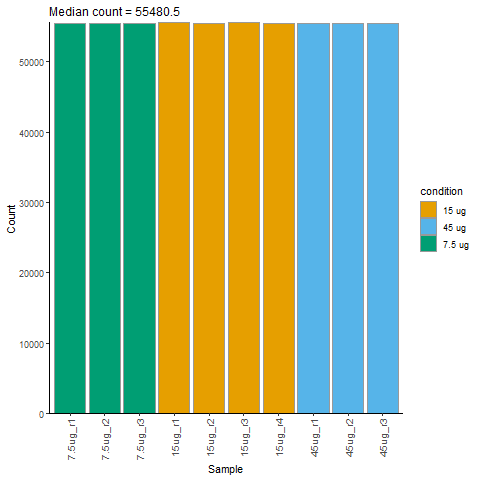

In [24]:
%%R
plotCount(pepdat)

In [25]:
%%R

prodat <- makeProteinTable(pepdat, aggregate.fun=aggregateHifly, hifly=3)
summary(prodat)


*** Basic statistics ***

  content = protein
  experiment type = TMT
  number of samples = 10
  number of conditions = 3
  number of proteins = 9624
  samples = 7.5ug_r1, 7.5ug_r2, 7.5ug_r3, 15ug_r1, 15ug_r2, 15ug_r3, 15ug_r4, 45ug_r1, 45ug_r2, 45ug_r3
  conditions = 15 ug, 45 ug, 7.5 ug

*** Data processing ***

  evidence columns used = Reporter intensity 0, Reporter intensity 1, Reporter intensity 2, Reporter intensity 3, Reporter intensity 4, Reporter intensity 5, Reporter intensity 6, Reporter intensity 7, Reporter intensity 8, Reporter intensity 9
  sequence = 'Sequence'
  protein = 'Leading razor protein'
  normalization = identity

*** Protein data ***

  quantification method = 
  minimum number of peptides per protein = 2


In [26]:
%%R
prodat.norm <- normalizeTMT(prodat)

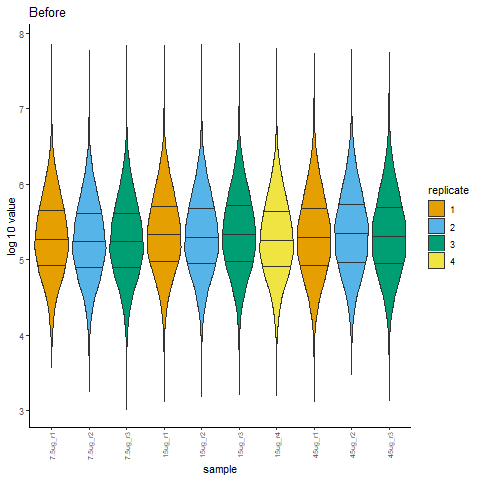

In [27]:
%%R
library(ggplot2)
plotSampleDistributions(prodat, fill="replicate") + labs(title="Before")

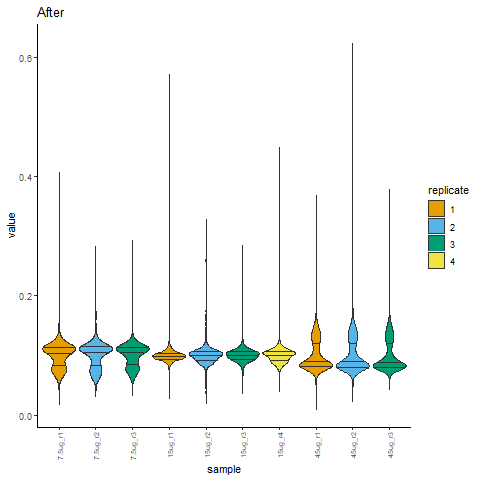

In [28]:
%%R
plotSampleDistributions(prodat.norm, log.scale=FALSE, fill="replicate") + labs(title="After")

In [29]:
%%R
res <- limmaDE(prodat.norm, conditions=c("7.5 ug", "15 ug"), sig.level=0.01)

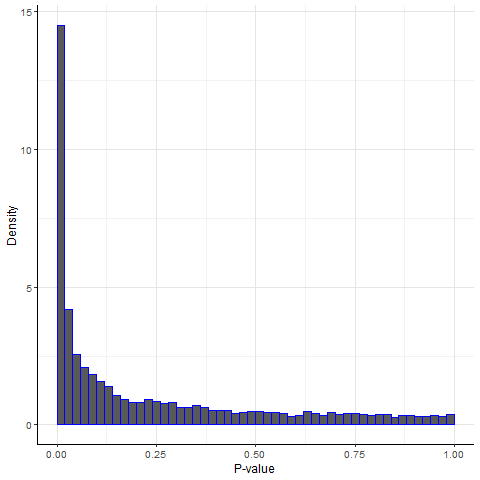

In [30]:
%%R
plotPdist(res)

In [31]:
%%R
res <- res[order(res$adj.P.Val),]
head(res)

                   protein      logFC   AveExpr         t      P.Value
1512  sp|P0A817|METK_ECOLI -0.6956350 -3.723934 -13.93763 5.237276e-07
4357  sp|P76177|YDGH_ECOLI -0.7490726 -3.855357 -13.32670 7.464598e-07
6059 sp|Q7Z570|Z804A_HUMAN  1.1504437 -3.221225  13.78189 5.724479e-07
2220  sp|P0AG27|YIBN_ECOLI -0.6440216 -3.766848 -12.37755 1.334987e-06
4536 sp|P77808|CINAL_ECOLI -0.6183769 -3.715006 -11.44223 2.466559e-06
1796  sp|P0ABA0|ATPF_ECOLI -0.7017861 -3.821625 -10.81488 3.820112e-06
       adj.P.Val        B significant mean_7.5 ug mean_15 ug ngood_7.5 ug
1512 0.001673065 6.684765        TRUE   -4.121440  -3.425805            3
4357 0.001673065 6.392836        TRUE   -4.283398  -3.534326            3
6059 0.001673065 6.612098        TRUE   -2.563828  -3.714272            3
2220 0.002244113 5.900384        TRUE   -4.134860  -3.490839            3
4536 0.003317029 5.363327        TRUE   -4.068364  -3.449987            3
1796 0.003669491 4.970813        TRUE   -4.222645  -3.52085

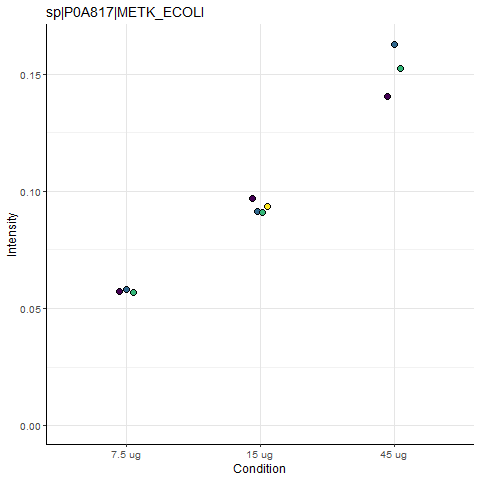

In [32]:
%%R
prot <- as.character(res$protein[1])
plotIntensities(prodat.norm, id=prot)

In [33]:
%%R
write.csv(res, "proteus.csv")

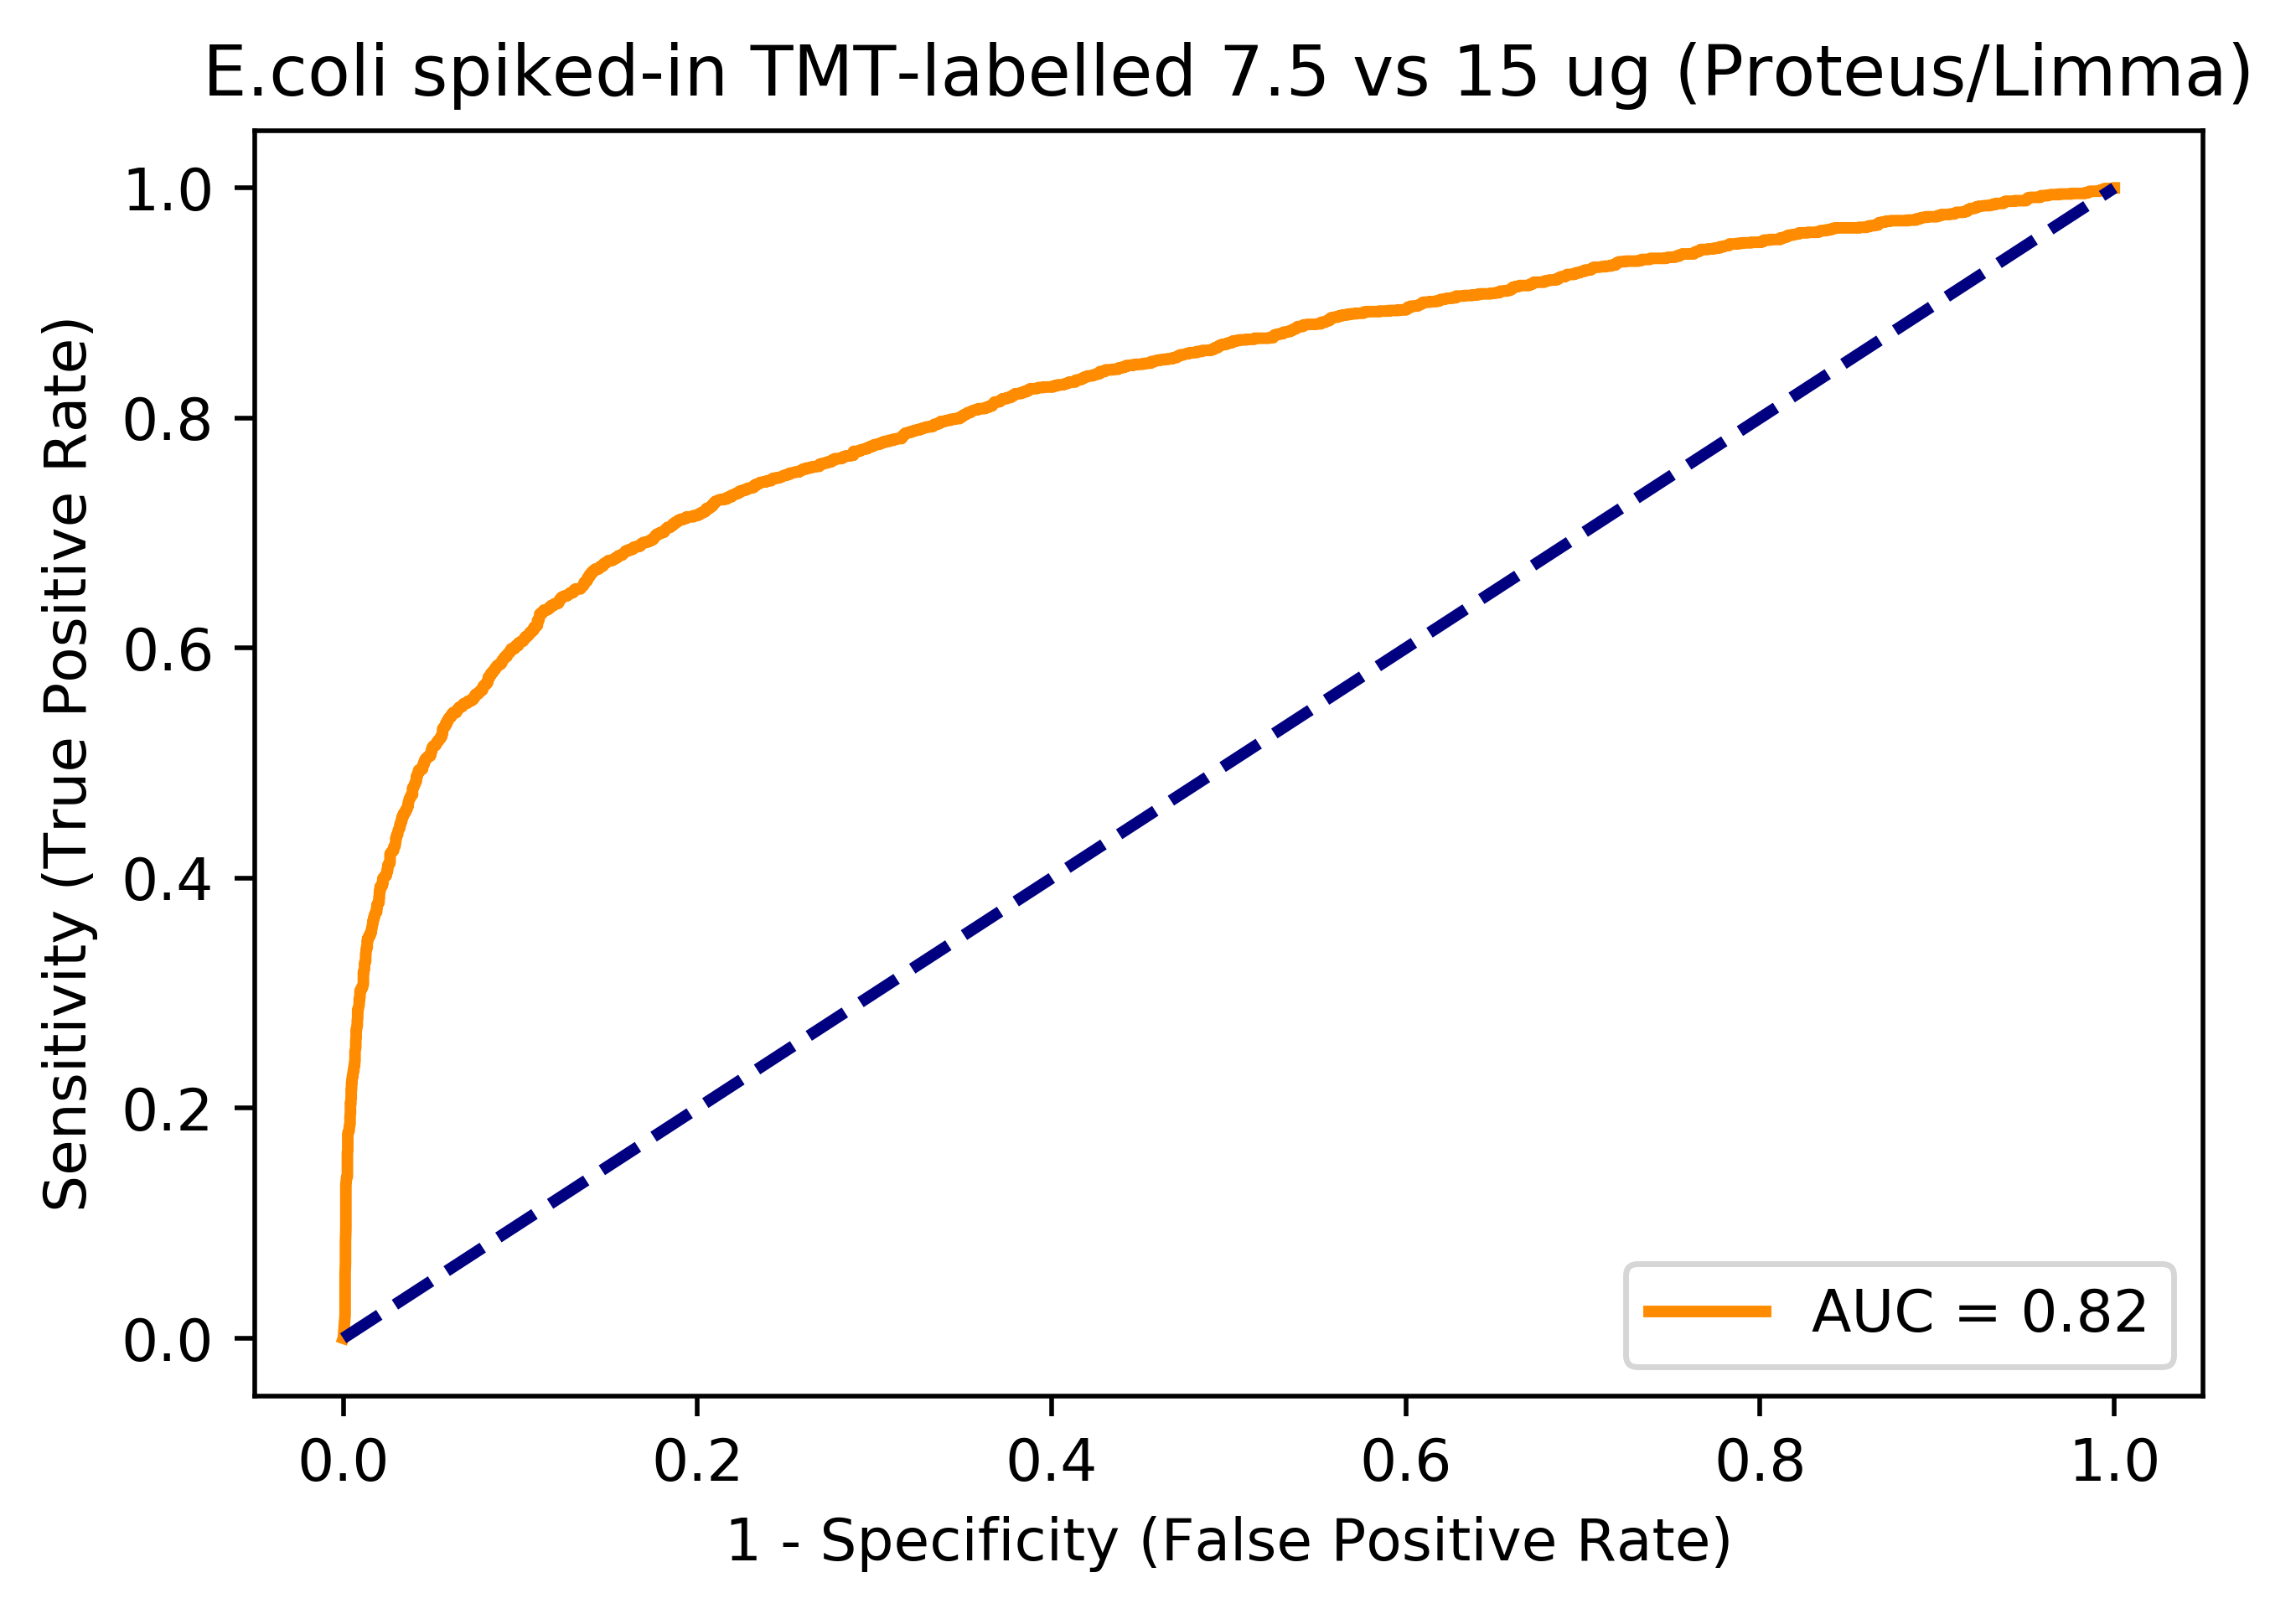

In [34]:
from sklearn import metrics

compar_res = pd.read_csv("proteus.csv", sep=',', header=0, index_col=0)
compar_res = compar_res[(compar_res['ngood_7.5 ug'] != 0) & (compar_res['ngood_15 ug'] != 0)]
compar_res['value'] = 1 - compar_res['adj.P.Val']
compar_res['y'] = compar_res['protein'].map(lambda x: ("ECOLI" in x and 1) or ("HUMAN" in x and 0))

compar_res = compar_res.sort_values(by="adj.P.Val", ascending=True)


fpr, tpr, thresholds = metrics.roc_curve(compar_res['y'].tolist(), compar_res['value'].tolist(), pos_label = 1)
auc = metrics.auc(fpr, tpr)

plt.figure(dpi=500)

plt.plot(fpr, tpr, color="darkorange", lw=2, label="AUC = %0.2f" % auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("E.coli spiked-in TMT-labelled 7.5 vs 15 ug (Proteus/Limma)")
plt.xlabel("1 - Specificity (False Positive Rate)")
plt.ylabel("Sensitivity (True Positive Rate)")
plt.legend(loc="lower right")

In [78]:
compar_res.head()

,protein,logFC,AveExpr,t,P.Value,adj.P.Val,B,significant,mean_7.5 ug,mean_15 ug,ngood_7.5 ug,ngood_15 ug,value,y
1512,sp|P0A817|METK_ECOLI,-0.695635,-3.723934,-13.937627,5.237276e-07,0.001673,6.684765,True,-4.121440,-3.425805,3,4,0.998327,1
4357,sp|P76177|YDGH_ECOLI,-0.749073,-3.855357,-13.326700,7.464598e-07,0.001673,6.392836,True,-4.283398,-3.534326,3,4,0.998327,1
6059,sp|Q7Z570|Z804A_HUMAN,1.150444,-3.221225,13.781893,5.724479e-07,0.001673,6.612098,True,-2.563828,-3.714272,3,4,0.998327,0
2220,sp|P0AG27|YIBN_ECOLI,-0.644022,-3.766848,-12.377549,1.334987e-06,0.002244,5.900384,True,-4.134860,-3.490839,3,4,0.997756,1
4536,sp|P77808|CINAL_ECOLI,-0.618377,-3.715006,-11.442229,2.466559e-06,0.003317,5.363327,True,-4.068364,-3.449987,3,4,0.996683,1


In [89]:
ecoli = compar_res[compar_res['protein'].str.contains('ECOLI')]
human = compar_res[compar_res['protein'].str.contains('HUMAN')]

TP = ecoli[ecoli['significant'] == True]
FP = human[human['significant'] == True]

In [90]:
TP

,protein,logFC,AveExpr,t,P.Value,adj.P.Val,B,significant,mean_7.5 ug,mean_15 ug,ngood_7.5 ug,ngood_15 ug,value,y
1512,sp|P0A817|METK_ECOLI,-0.695635,-3.723934,-13.937627,5.237276e-07,0.001673,6.684765,True,-4.121440,-3.425805,3,4,0.998327,1
4357,sp|P76177|YDGH_ECOLI,-0.749073,-3.855357,-13.326700,7.464598e-07,0.001673,6.392836,True,-4.283398,-3.534326,3,4,0.998327,1
2220,sp|P0AG27|YIBN_ECOLI,-0.644022,-3.766848,-12.377549,1.334987e-06,0.002244,5.900384,True,-4.134860,-3.490839,3,4,0.997756,1
4536,sp|P77808|CINAL_ECOLI,-0.618377,-3.715006,-11.442229,2.466559e-06,0.003317,5.363327,True,-4.068364,-3.449987,3,4,0.996683,1
1796,sp|P0ABA0|ATPF_ECOLI,-0.701786,-3.821625,-10.814883,3.820112e-06,0.003669,4.970813,True,-4.222645,-3.520859,3,4,0.996331,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999,sp|P0ADU5|YGIW_ECOLI,-0.411097,-3.642871,-5.261561,6.985616e-04,0.009765,-0.128342,True,-3.877783,-3.466686,3,4,0.990235,1
1847,sp|P0ABY4|FLAW_ECOLI,-0.358195,-3.595325,-5.257934,7.017069e-04,0.009789,-0.132942,True,-3.800008,-3.441813,3,4,0.990211,1
2342,sp|P10384|FADL_ECOLI,-0.504113,-3.693274,-5.251378,7.074312e-04,0.009828,-0.141260,True,-3.981339,-3.477226,3,4,0.990172,1
2925,sp|P26648|FTSP_ECOLI,-0.368814,-3.577160,-5.243766,7.141414e-04,0.009901,-0.150927,True,-3.787910,-3.419097,3,4,0.990099,1


In [92]:
len(FP)

23

In [93]:
len(ecoli)

2074